# RAI Exercise 1: Algorithmic Fairness ⚖️

# Important information
This exercise is part of the RAI course (02517 - **Responsible AI: Algorithmic Fairness and Explainability**) at the Technical University of Denmark (DTU). You can find more details about the course [here](https://kurser.dtu.dk/course/02517). This specific version is for the Fall 2024 semester.

If you have any questions related to this notebook, feel free to reach out to Nina Weng at *ninwe@dtu.dk*.

**Credits**:  
We thank:
* NIH dataset team for collecting such dataset [link to the paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf);
* Authors from [this paper](https://link.springer.com/chapter/10.1007/978-3-031-45249-9_14) for providing the splits;
* [Memes generator webpage imgflip](https://imgflip.com/) for all the excellent Memes template.


# PART 1: Fairness assessment and Bias mitigation using Fairlearn

The goal of this exercise is to learn how to use [Fairlearn](https://fairlearn.org/) to approach basic fairness assessments and apply post-processing bias mitigation methods. 

Fairlearn is an open-source Python package originally developed by Microsoft Research. Since 2021, it has become completely community-driven. For more information about Fairlearn, you can visit [this page]((https://fairlearn.org/v0.10/about/index.html)). 

Although Fairlearn is likely the most well-developed package targeting fairness issues, it has its limitations. The most notable limitation, that might need to be mentioned at very beginning for this exercise, is that Fairlearn is primarily designed for tabular data ([this page](https://fairlearn.org/main/faq.html) under question: *Does Fairlearn work for image and text data?*). Therefore, when working with other types of data, such as image data, unexpected issues may arise. Fortunate enough, there are workarounds for most of these issues, which will be discussed later in this exercise.

While Fairlearn is a good resource and offers an easy approach for learning fairness concepts and handling lighter tasks, it may not be the best solution for researchers working extensively in this area. Keep that in mind :-)

## 🧠 Objective of this Exercise (PART 1)
By the end of this exercise, you should be able to:

* Assess fairness using Fairlearn with provided predictions/probabilities and target labels. This includes calculating metrics, generating ROC curves, and interpreting their meaning.
* Apply post-processing bias mitigation techniques using Fairlearn, and clearly understand and explain the outcomes.

![](./support4notebook/getstarted.jpg)

## 1. Dataset: Chest X-ray and lung/heart related disease


In this exercise, we will use a chest X-ray dataset and a basic deep learning model as the setup. It requires the following:

* Download the dataset/metadata/pretrained ResNet model. Note that in this exercise, we only use part of the data, and details are listed below. The full dataset can be found [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). (For students in the class, you can find a download link on DTU Learn. For those not in the class, you can find the pre-processing scripts in [this repository](https://github.com/nina-weng/detecting_causes_of_gender_bias_chest_xrays).)
* After downloading the materials, put the `NIH_train_val_test_rs0_f50.csv` under `./datafiles/`; and `nih_pneumothorax.pth` under `./pretrained_model/`.
* Prepare your virtual environment: 
`conda env create -f env.yml`


### Chest xray samples
We use [NIH chest xray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) in this exercise. Let’s take a closer look at the dataset. </br>

This dataset contains 108,948 images from 32,717 patients, each labeled with one of 14 types of lung or heart-related diseases/symptoms. For detailed information on each disease, you can find explanations [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/220660789610).

For simplicity, we will use only one sample per patient and preprocess the images to a size of 224x224. Both the dataset and the metadata (in CSV format) are available. The dataset split is also specified in the metadata under the column 'split'.

Note: The split was designed for a different task, which required a larger test set than usual. As a result (as you’ll notice), the test set is relatively large (around 8k for training, 2k for validation, and 8k for testing). If you find that the mitigation or prediction process takes too long, feel free to downsample the test set. Just ensure you validate that the proportions of samples across different sensitive groups and disease labels remain roughly consistent with the original test set.  

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import torch

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate


#
from train.model import ResNet
from train.prediction import validate
from analysis.plot import plot_roc_simple
from analysis.tools import from_loader_to_tensor

In [10]:
#TODO: change this to your data directory
# datadir = r"materials_fairnessexercise_RAI_2024fall"
datadir = r"C:\Users\Documents\Johan\ResponsibleAI_Project1\data"

Let us take a look of some samples, with filter query. 

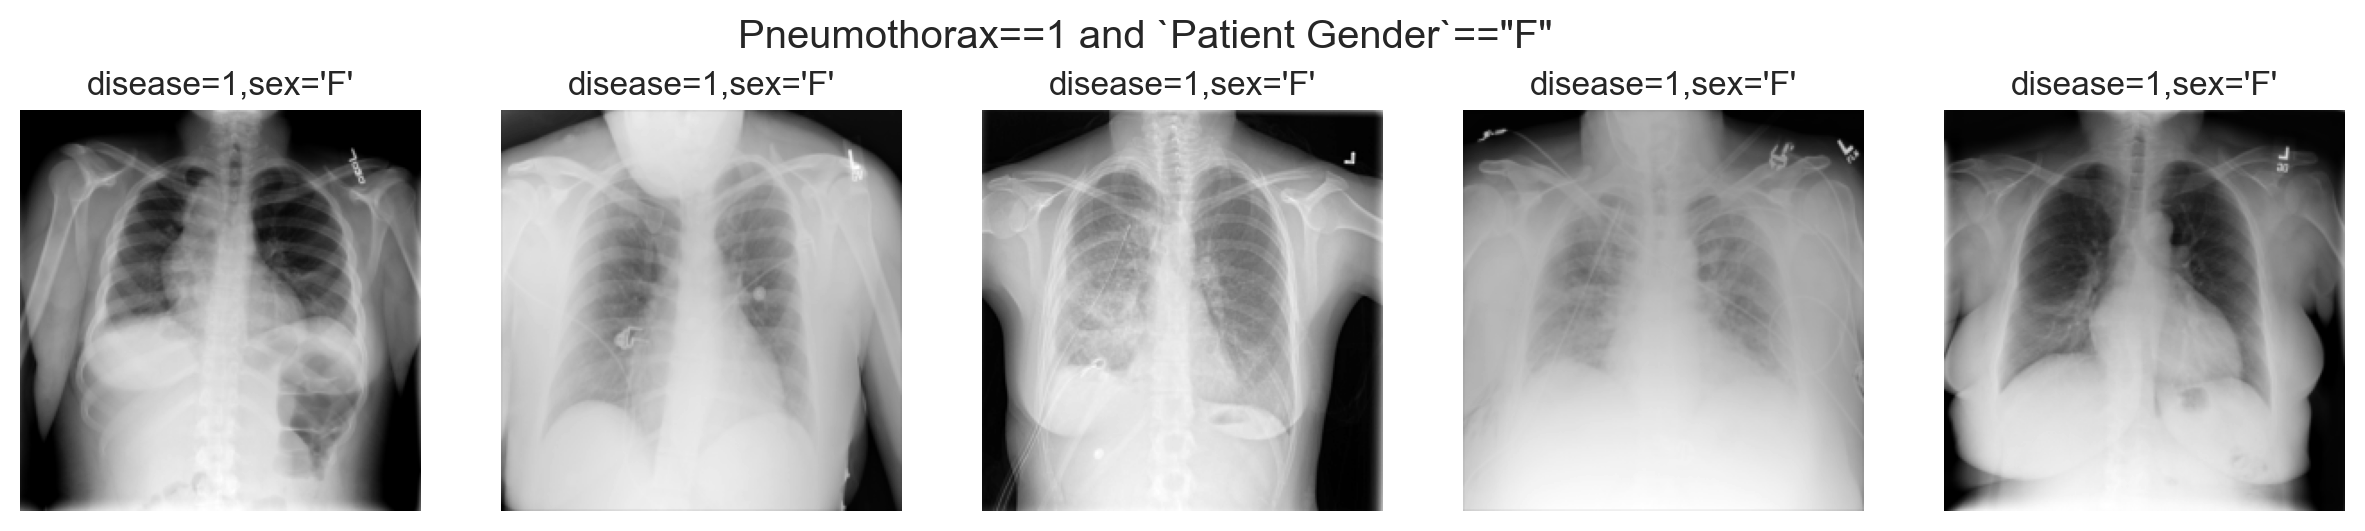

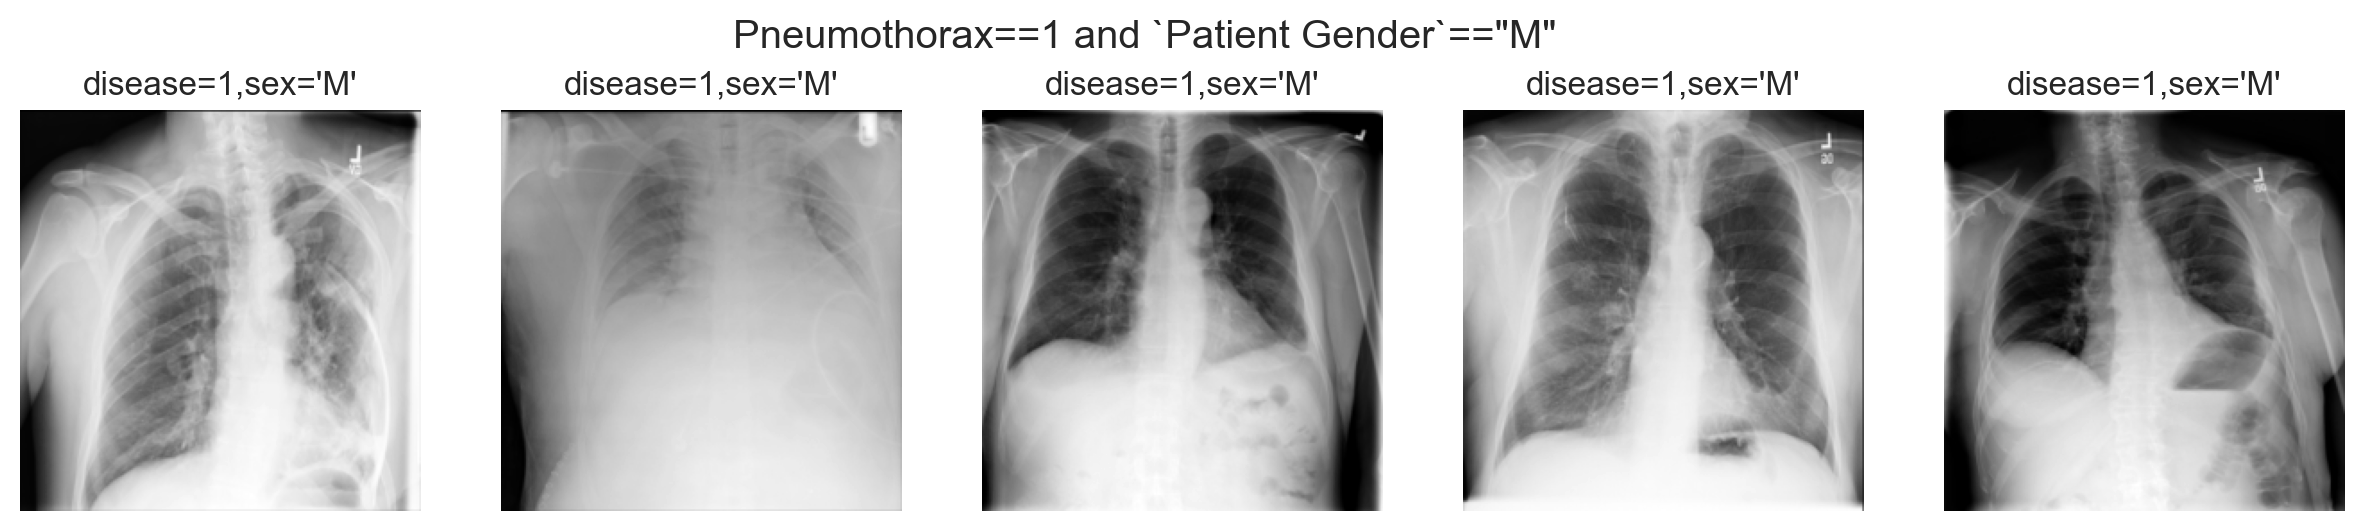

In [11]:
dataset_pth = datadir + '/NIH_part/'
metadata_csv = f"{datadir}/NIH_train_val_test_rs0_f50.csv"
metadata = pd.read_csv(metadata_csv)

# display(metadata.head(5))

# randomly choose some samples from PAD-UFES-20
def show_random_images(datadir,metadata,seed=None,filter_str=None,num_sample=5):
    fig = plt.figure(figsize=(num_sample*3, 3),dpi=200)
    files = os.listdir(datadir)
    if filter_str:
        metadata = metadata.query(filter_str)
        # display(metadata.head(5))
    if seed is not None:
        random_sample = metadata.sample(n=num_sample, random_state=seed)
    else: random_sample = metadata.sample(n=num_sample)
    
    for i in range(len(random_sample)):
        row = random_sample.iloc[i]
        disease = row['Pneumothorax']
        sex = row['Patient Gender']

        img = mpimg.imread(datadir + row['Image Index'])
        ax = fig.add_subplot(1, len(random_sample), i + 1)
        # add diagnosis as subtitle
        ax.set_title(f'{disease=},{sex=}')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle(f'{filter_str}')
    plt.show()

show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="F"',num_sample=5)
show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="M"',num_sample=5)

### Basic statistics

We can also take a look at the distribution of some sensitive attributes:

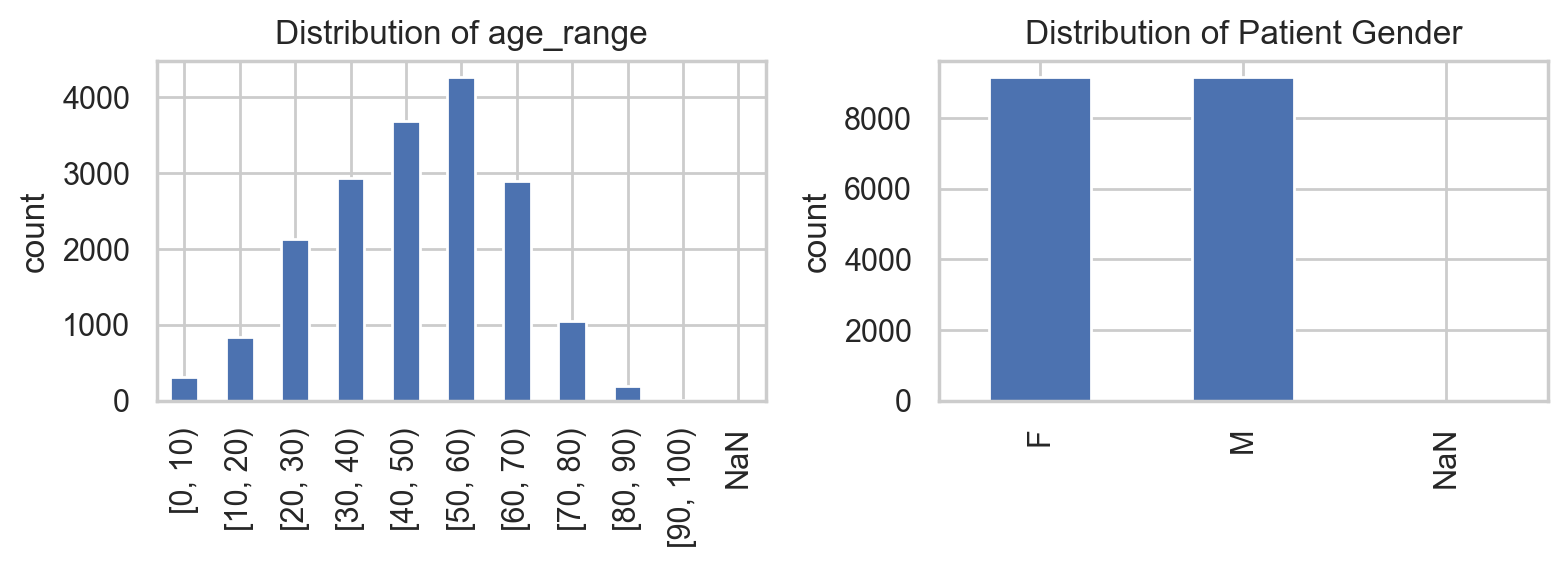

In [12]:
def plot_distribution_by_value(metadata, column_name):
    if isinstance(column_name, str):
        nan_count = metadata[column_name].isna().sum()
        nan_series = pd.Series([nan_count], index=['NaN'])
        counts_ = metadata[column_name].value_counts().sort_index()
        counts_with_nan = pd.concat([counts_, nan_series])

        counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(column_name))
        plt.ylabel('count')
    elif isinstance(column_name, list):
        fig, axes = plt.subplots( 1, len(column_name), figsize=( len(column_name)*4,3),dpi=200)
        for i,col in enumerate(column_name):
            nan_count = metadata[col].isna().sum()
            nan_series = pd.Series([nan_count], index=['NaN'])
            counts_ = metadata[col].value_counts().sort_index()
            counts_with_nan = pd.concat([counts_, nan_series])

            counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(col),ax=axes[i])
            axes[i].set_ylabel('count')
    plt.tight_layout()
    plt.show()

metadata['age_range'] = pd.cut(metadata['Patient Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], right=False)
plot_distribution_by_value(metadata, ['age_range','Patient Gender'])

You may have noticed that, for this specific split, we maintain an equal number of male and female samples. This balance is consistent across all three splits: training, validation, and testing.

### 📃 Further Reading:
If you're interested, here are some studies that explore potential biases and confounders in chest xray datasets:
* [Lauren Oakden-Rayner: Exploring the ChestXray14 dataset: problems](https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/)
* [Amelia Jiménez-Sánchez et al.: Detecting Shortcuts in Medical Images -- A Case Study in Chest X-rays](https://arxiv.org/abs/2211.04279)
* [Judy Wawira Gichoya et al.: AI recognition of patient race in medical imaging: a modelling study](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00063-2/fulltext)

## 2. Fairness assessment
**Recap of Key Concepts**:

In th class, we have learned:
* The three key criteria for fairness assessment. What are they?
* Evaluation metrics corresponding to each criterion.
* ROC curves.

For this exercise, we’ve provided a pre-trained ResNet classifier for Part 1, where the disease label is `Pneumothorax` and the sensitive attribute is `sex` (in metadata, you can get the binarized sex label from column `sex label`, where 0 represents female and 1 represents male). However, feel free to train your own model if you'd like.



### Load pretrained model

In [13]:
# load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(' device:', device)

ds_name = 'NIH'

# load the model
lr=1e-6
pretrained = True
model_scale = '18'
num_epochs =20
img_size = (1, 224, 224)

classifier = ResNet(num_classes=1, lr=lr, pretrained=pretrained, model_scale=model_scale, in_channel=img_size[0])
classifier.load_state_dict(torch.load(f'{datadir}/nih_pneumothorax.pth', map_location=torch.device(device)))
classifier.to(device)

classifier.eval()


 device: cuda


c:\Users\HyperTron\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HyperTron\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Load test and validation data

In [14]:
save_model_at = f'./pretrained_models/'

img_size = (1,224,224)
batch_size = 16

csv_pth = f'{datadir}/NIH_train_val_test_rs0_f50.csv' if ds_name == 'NIH' else None

disease_label = 'Pneumothorax' 
sensitive_label = 'sex'
augmentation = False

from train.train_chestxray import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(dataset_pth, 
                                                               ds_name,
                                                               csv_pth, 
                                                               image_size=img_size, 
                                                               device=device,
                                                               disease_label = disease_label,
                                                               sensitive_label = sensitive_label,
                                                               augmentation=augmentation)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we dont need it here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 8459/8459 [00:00<00:00, 60037.05it/s]


### Predict the results for test set

In [15]:
#_-_-_-_-_-_-_-_-_-_-_-
# Load the model from a pickle dump (dont need to wait 10 minutes in case of cpu)
#_-_-_-_-_-_-_-_-_-_-_-

# test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

import pickle

results_path = 'test_results.pkl'

# Validate the model (or comment this out to skip running it if already saved)
if not os.path.exists(results_path):
    print("Running validation (this may take a while)...")
    test_lab, test_pred, test_prob, test_a = validate(classifier, test_loader, device=device)
    
    # Save the validation results
    with open(results_path, 'wb') as f:
        pickle.dump((test_lab, test_pred, test_prob, test_a), f)
else:
    print("Loading saved validation results...")
    # Load the saved results if they already exist
    with open(results_path, 'rb') as f:
        test_lab, test_pred, test_prob, test_a = pickle.load(f)

# Now you can use test_lab, test_pred, test_prob, and test_a
print("done")

Loading saved validation results...
done


### Assess fairness using Fairlearn
#### A simple example first

Fairlearn provides the `fairlearn.metrics.MetricFrame` class to help with this quantification. 

Given: 
<pre>
y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
           'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']
</pre>
           


![](./support4notebook/exercise_time.gif)

Try: 
* measure: recall, selection rate and false positive rate for *each group*;
* plot the above result out; ([Hint](https://fairlearn.org/main/user_guide/assessment/plotting.html))
* measure the difference in eqaulized odd between different groups;


Hint: The documentation page of [MetricFrame](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.MetricFrame.html#fairlearn.metrics.MetricFrame)

### Now measure the fairness metrics for our data

![](./support4notebook/exercise.jpg)

In [16]:
mf = MetricFrame(metrics={'accuracy': accuracy_score,
                        # recall, selection rate and false positive rate 
                        'selection_rate': selection_rate,
                        'false_positive_rate': false_positive_rate,
                        'recall': true_positive_rate,
                         },
                 y_true=test_lab,
                 y_pred=test_pred,
                 sensitive_features=test_a)

print("Test set fairness metrics (before mitigation):")
print(mf.by_group)

Test set fairness metrics (before mitigation):
                     accuracy  selection_rate  false_positive_rate    recall
sensitive_feature_0                                                         
0.0                  0.769213        0.244029             0.222028  0.619658
1.0                  0.849173        0.155556             0.137957  0.556180


### Draw the ROC curve

Here we provide the funtion `plot_roc_simple` to draw the ROC curve for each groups.

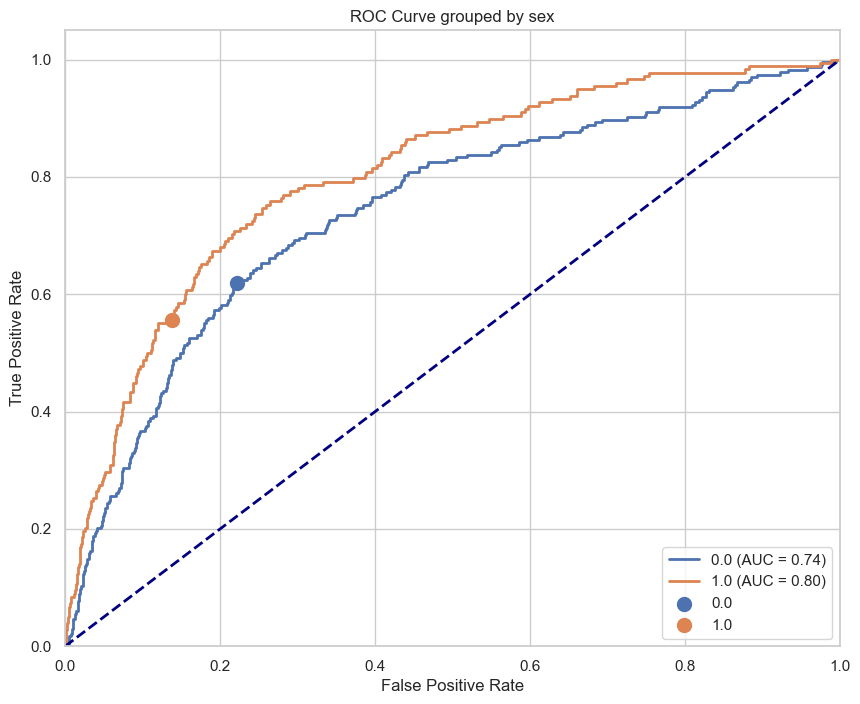

In [17]:
plot_roc_simple(test_lab, test_prob, test_a, test_pred,
        sensitive_attribute_name = 'sex',
        )

### 💥 Exercise and discusssion:
* What do you see from the metrics and the ROC curve?
* Try to measure and desribe the fairness wrt the 3 creterias we learned from class

## 3. Bias mitigation using Fairlearn

### Recall from the class
* what kinds of mitigation methods have we learned?

In this exercise, we will try to use the one pf the post-preprocessing bias mitiagtion method Fairlearn provided: **Threshold Optimization**, to implement the bias mitigation steps. 

### The theory of Threshold Optimization


The idea could be simply visualized as below (figure from the [original paper](https://arxiv.org/pdf/1610.02413)):  
![](./support4notebook/threshold_op.png)

Where blue/green represent two sensitive groups, any points in the overlapping region meet the requirement of equalized odds:

$$
\gamma_0(\hat{Y}) = \gamma_1(\hat{Y}),
$$

where 

$$
\gamma_a (\hat{Y}) = \left(Pr(\hat{Y} = 1 | A = a, Y = 0), Pr(\hat{Y} = 1 | A = a, Y=1)\right).
$$

The goal of the threshold optimizer is to find the point in the overlapping region that optimizes the objective function, such as balanced accuracy.

To achieve this, **randomization** is introduced. The idea is starightforward: any point under the ROC curve can be estimated by weighting two points on the ROC curve (which could be achieved by simply thresholding); or in another word, a new decision threshold $T_a$ can be a randomized mixture of two decision thresholds $\underline{t}_a$ and $\overline{t}_a$.

(See the figure below, which is from [this paper](https://arxiv.org/abs/2202.08536)).

![Randomization Figure](./support4notebook/randomization.png)


📃 Further Reading:
* [Fairlearn *ThresholdOptimizier* page](https://fairlearn.org/v0.5.0/api_reference/fairlearn.postprocessing.html).
* The original paper (See section 3): [Equality of opportunity in supervised learning](https://arxiv.org/pdf/1610.02413).




### 🪄 Trick: A fake classifier class

Fairlearn has some limitations when implementing the `ThresholdOptimizer` method. To work around these issues, a fake classifier is provided to bypass minor problems. If you use the provided classifier, this fake class should work just as well.

However, if you're curious about what went wrong or want to use your own classifier, please read below:

* **Problem 1: `estimator` in `ThresholdOptimizer` only accepts 2D input (tabular data).** This doesn’t make sense for post-processing mitigation methods, as the only relevant aspect here is the prediction scores from the test set. The classifier itself and the input data are irrelevant when optimizing the threshold.
  
* **Problem 2: The `prefit` parameter checks whether the model has been fitted in a simplistic way, leading to errors.** You can read more about this fit check function [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.validation.check_is_fitted.html).
  
* **Problem 3: It requires the prediction function to return scores for both classes in binary classification.** This might be an issue if your classifier only provides the probability for class 1.

**How we solve this**: We create a fake classifier that accepts 2D input and reshapes it back to the original image size before feeding it into the prediction function. We trick the fit check by defining a fake variable and manually modify the output of the prediction function to include both classes if it only returns the probability for class 1.

Note: If you trained your own classifier, you will need to implement a custom fake classifier yourself.

In [18]:
import numpy as np
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
# remove future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class FakeClassifierInput2D(BaseEstimator, ClassifierMixin):
    '''
    Fake classifier that takes 2D input, with pre-trained model that does not take 2D input data
    '''
    def __init__(self, model, img_size, num_classes=1):
        self.model = model
        self.img_size = img_size
        self.num_classes = num_classes
        self.input_from_2D_func = lambda x: torch.reshape(x, (-1,) + self.img_size)
        self.fit_ = True

    def fit(self, X, y):
        # Do not need to fit
        pass

    def predict(self, X, batch_size=64):
        self.model.eval()
        predicted_list = []
        with torch.no_grad():
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                X_tensor = X_batch.type(torch.FloatTensor)
                X_tensor = self.input_from_2D_func(X_tensor)
                outputs = self.model(X_tensor)
                if self.num_classes == 1:
                    outputs = outputs.view(-1)
                    prob_pos = torch.sigmoid(outputs)
                    predicted = (prob_pos > 0.5).float()
                else:
                    prob = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(prob, 1)
                predicted_list.append(predicted.cpu().numpy())
        return np.concatenate(predicted_list, axis=0)

    def predict_proba(self, X_2D, batch_size=64):
        self.model.eval()
        proba_list = []
        with torch.no_grad():
            for i in range(0, X_2D.shape[0], batch_size):
                X_batch_2D = X_2D[i:i+batch_size]
                X = self.input_from_2D_func(X_batch_2D)
                X_tensor = X.type(torch.FloatTensor)
                outputs = self.model(X_tensor)
                outputs = outputs.view(-1)  # Ensure outputs are of shape (batch_size,)
                prob_pos = torch.sigmoid(outputs)  # Probability of positive class (class 1)
                prob_neg = 1 - prob_pos           # Probability of negative class (class 0)
                # Stack probabilities along the second dimension
                prob = torch.stack([prob_neg, prob_pos], dim=1)  # Shape: (batch_size, 2)
                proba_list.append(prob.cpu().numpy())
        return np.concatenate(proba_list, axis=0)


### Optimize on validation set

In [19]:
X_test, y_test, a_test = from_loader_to_tensor(test_loader,device)
X_val, y_val, a_val = from_loader_to_tensor(val_loader,device)

X_test_2D = torch.reshape(X_test,(X_test.shape[0],-1))
X_val_2D = torch.reshape(X_val,(X_val.shape[0],-1))

100%|██████████| 529/529 [00:15<00:00, 34.38it/s]


X.shape=torch.Size([8459, 1, 224, 224]), y.shape=torch.Size([8459]), a.shape=torch.Size([8459])


100%|██████████| 89/89 [00:02<00:00, 33.74it/s]


X.shape=torch.Size([1409, 1, 224, 224]), y.shape=torch.Size([1409]), a.shape=torch.Size([1409])


In [20]:
classifier_fake = FakeClassifierInput2D(
    model=classifier.to('cpu'),
    img_size=img_size,
    num_classes=2
)


Your code here:

In [21]:
# Ensure that y_proba_val has probabilities for both classes
y_proba_val = classifier_fake.predict_proba(X_val_2D, batch_size=batch_size)
print(f"Shape of y_proba_val: {y_proba_val.shape}")  # Should be (n_samples, 2)

# Extract probabilities for the positive class
y_proba_pos = y_proba_val[:, 1]

# Compute ROC curves for each sensitive group
from sklearn.metrics import roc_curve

group_0_indices = (a_val == 0)
group_1_indices = (a_val == 1)

fpr0, tpr0, thresholds0 = roc_curve(y_val[group_0_indices], y_proba_pos[group_0_indices])
fpr1, tpr1, thresholds1 = roc_curve(y_val[group_1_indices], y_proba_pos[group_1_indices])


Shape of y_proba_val: (1409, 2)


In [22]:
from fairlearn.postprocessing import ThresholdOptimizer

thresh_opt = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='equalized_odds',
    objective='balanced_accuracy_score',
    predict_method='predict_proba',
    prefit=True
)

# Fit the ThresholdOptimizer
thresh_opt.fit(X_val_2D, y_val, sensitive_features=a_val)

# Get the adjusted predictions
y_pred_thresh = thresh_opt.predict(X_val_2D, sensitive_features=a_val)
print(f"Shape of y_pred_thresh: {y_pred_thresh.shape}")  # Should be (n_samples,)


Shape of y_pred_thresh: (1409,)


In [23]:
from sklearn.metrics import confusion_matrix

# For sensitive group 0
y_true0 = y_val[group_0_indices]
y_pred0 = y_pred_thresh[group_0_indices]
cm_0 = confusion_matrix(y_true0, y_pred0)
tn_0, fp_0, fn_0, tp_0 = cm_0.ravel()
fpr_opt_0 = fp_0 / (fp_0 + tn_0)
tpr_opt_0 = tp_0 / (tp_0 + fn_0)

# For sensitive group 1
y_true1 = y_val[group_1_indices]
y_pred1 = y_pred_thresh[group_1_indices]
cm_1 = confusion_matrix(y_true1, y_pred1)
tn_1, fp_1, fn_1, tp_1 = cm_1.ravel()
fpr_opt_1 = fp_1 / (fp_1 + tn_1)
tpr_opt_1 = tp_1 / (tp_1 + fn_1)


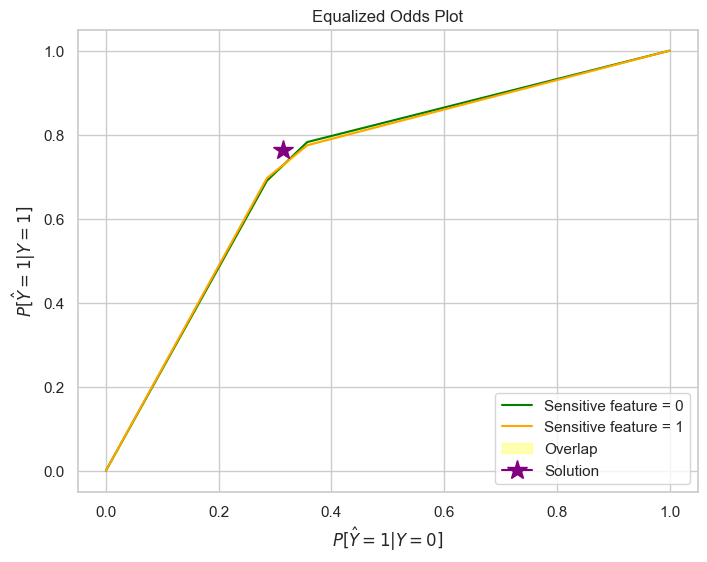

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to compute TPR and FPR for each group
def compute_tpr_fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

# Compute TPR and FPR for each sensitive group
fpr0, tpr0 = compute_tpr_fpr(y_val[group_0_indices], y_pred_thresh[group_0_indices])
fpr1, tpr1 = compute_tpr_fpr(y_val[group_1_indices], y_pred_thresh[group_1_indices])

# Interpolated TPR and FPR to smooth the curve but with fewer points
fpr_common = np.linspace(0, 1, 15)  # Reduce the number of points to 50
tpr0_interp = np.interp(fpr_common, [0, fpr0, 1], [0, tpr0, 1])
tpr1_interp = np.interp(fpr_common, [0, fpr1, 1], [0, tpr1, 1])

# Create the plot
plt.figure(figsize=(8, 6))

# Plot sensitive feature = 0
plt.plot(fpr_common, tpr0_interp, label='Sensitive feature = 0', color='green')

# Plot sensitive feature = 1
plt.plot(fpr_common, tpr1_interp, label='Sensitive feature = 1', color='orange')

# Highlight overlapping region
overlap_lower = np.maximum(np.minimum(tpr0_interp, tpr1_interp), 0)
overlap_upper = np.minimum(np.maximum(tpr0_interp, tpr1_interp), 1)
plt.fill_between(fpr_common, overlap_lower, overlap_upper, color='yellow', alpha=0.3, label='Overlap')

# Mark the final threshold solution (assumed point for illustration)
solution_fpr = (fpr0 + fpr1) / 2
solution_tpr = (tpr0 + tpr1) / 2
plt.plot(solution_fpr, solution_tpr, marker='*', color='purple', markersize=15, label='Solution')

# Labels and title
plt.xlabel(r'$P[\hat{Y} = 1 | Y = 0]$')
plt.ylabel(r'$P[\hat{Y} = 1 | Y = 1]$')
plt.title('Equalized Odds Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Use the new threshold for the test set

Your code here:

In [25]:
# # Obtain adjusted predictions using the ThresholdOptimizer
# y_pred_test_thresh = thresh_opt.predict(X_test_2D, sensitive_features=a_test)


In [26]:
# File path to save/load the thresholded predictions
thresh_predictions_path = 'thresh_predictions.pkl'

if not os.path.exists(thresh_predictions_path):
    print("Running thresholded predictions (this may take a while)...")

    # Get thresholded predictions with the sensitive features
    y_pred_test_thresh = thresh_opt.predict(X_test_2D, sensitive_features=a_test)

    # Save the thresholded predictions to avoid re-running in the future
    with open(thresh_predictions_path, 'wb') as f:
        pickle.dump(y_pred_test_thresh, f)

else:
    print("Loading saved thresholded predictions...")
    
    # Load the saved thresholded predictions
    with open(thresh_predictions_path, 'rb') as f:
        y_pred_test_thresh = pickle.load(f)

# Now you can use y_pred_test_thresh
print("Thresholded predictions loaded and ready for use.")

Loading saved thresholded predictions...
Thresholded predictions loaded and ready for use.


In [27]:
# Create the MetricFrame
mf_post = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'recall': true_positive_rate  # Recall is the same as TPR
    },
    y_true=y_test,
    y_pred=y_pred_test_thresh,
    sensitive_features=a_test
)

# Print the fairness metrics by group
print("Test set fairness metrics (after mitigation):")
print(mf_post.by_group)

Test set fairness metrics (after mitigation):
                     accuracy  selection_rate  false_positive_rate    recall
sensitive_feature_0                                                         
0.0                  0.677702        0.344999             0.323905  0.705128
1.0                  0.648227        0.370213             0.354886  0.719101


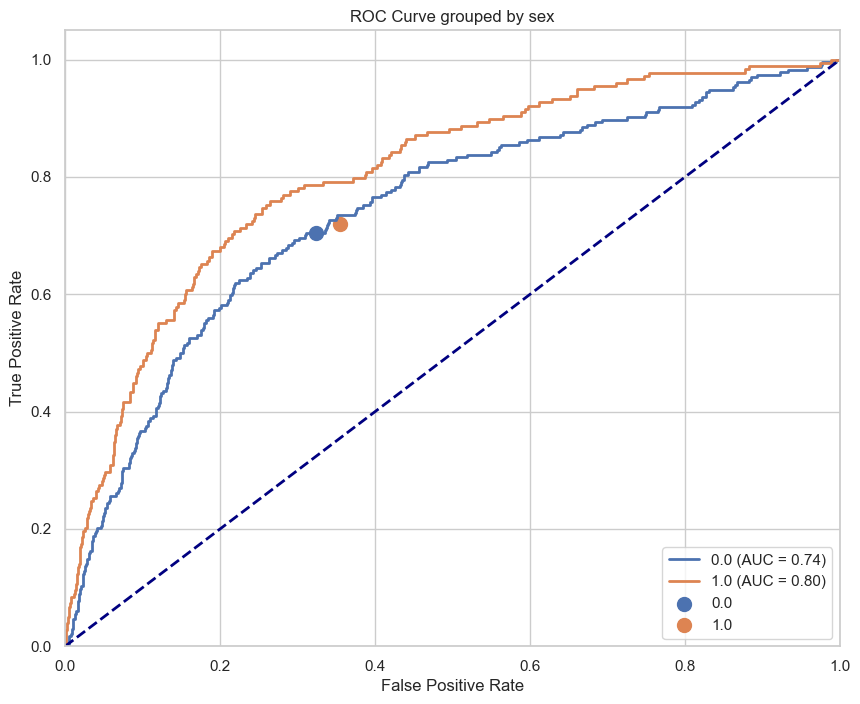

In [28]:
plot_roc_simple(test_lab, test_prob, test_a, y_pred_test_thresh,
        sensitive_attribute_name = 'sex',
        )

### To find out how the prediction come from (the new threshold $T_a$)

In [29]:
import json

# Access the threshold rules
threshold_rules_by_group = thresh_opt.interpolated_thresholder_.interpolation_dict

# Print the threshold rules in a readable format
print("Threshold rules by group:")
print(json.dumps(threshold_rules_by_group, default=str, indent=4))

Threshold rules by group:
{
    "0.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.317,
        "p0": 0.9932222222222229,
        "operation0": "[>0.3068544417619705]",
        "p1": 0.006777777777777105,
        "operation1": "[>0.2707941234111786]"
    },
    "1.0": {
        "p_ignore": 0.11022723354625812,
        "prediction_constant": 0.317,
        "p0": 0.5154907975460122,
        "operation0": "[>0.24994415789842606]",
        "p1": 0.48450920245398776,
        "operation1": "[>0.0645340234041214]"
    }
}


### 💥 Exercise and Discussion:
* Can you write down the new threshold function? ([Hint](https://fairlearn.org/v0.10/user_guide/mitigation/postprocessing.html#postprocessing))
* Compare the results. What do you observe, and does this model seem fair to you?
* Hint: After optimization, you may notice that accuracy (or other metrics) is more balanced between groups. However, the overall accuracy (or other metrics of interest) may decrease for both groups. Do you think this is still a good or acceptable solution?


For individuals in sensitive group 0.0, the model will:

•	Predict class 1 if the prediction score is greater than 0.30685435235500336.

•	Otherwise, predict class 0 unless the score is between 0.27079467475414276 and 0.30685435235500336.

For individuals in sensitive group 1.0, the model will:

•	Predict class 1 if the prediction score exceeds 0.24994411319494247.

•	Predict class 0 for scores below that.

This adjusted threshold function makes sure the performance (TPR and FPR) is balanced between the two groups.


. Observations and Discussion

	•	Fairness: After applying the threshold optimizer, you likely noticed that the false positive rate (FPR) and true positive rate (TPR) are more balanced between the groups. This suggests that the model has achieved greater fairness under the equalized odds criterion.
	•	Overall Accuracy: One common side effect of enforcing fairness constraints is a decrease in overall performance metrics (e.g., accuracy) across the groups. This is due to the model needing to adjust its predictions for one or more groups, which may involve lowering its predictive performance on the majority group to maintain fairness.
	•	Is this a good solution?
	•	If your goal is to ensure that the model treats different demographic groups fairly, this might be an acceptable trade-off. The sacrifice in accuracy for better fairness could be warranted depending on the application (e.g., sensitive fields like criminal justice or lending).
	•	However, if predictive performance is paramount, and fairness constraints significantly degrade overall accuracy, you might want to consider alternative approaches, such as adjusting for fairness earlier in the modeling process (e.g., through representation learning or in-processing techniques).


![](./support4notebook/dilemma.jpg)

# PART 2: Potential pitfall: Algorithmic fairness in the presence of label noise
As mentioned in class, it is easy to diagnose algorithmic bias. This is, however, only true if we have access to correct target labels for the test set. In this part of the project, we will simulate a situation where our test set ground truth target labels are incorrect in a biased way: You will simulate overdiagnosis among male individuals, by manually distorting some of their labels. Next, you will analyze how this affects the diagnosis and mitigation of algorithmic bias.

## Write a script to distort the labels for the male individuals according to the following recipe:
* Please create a new set of distorted target labels
* Initialize these as identical to the supplied target labels
* Manually distort them by flipping 30% of the healthy labels for male individuals to diseased. These should be selected at random.

## Now repeat your analysis from Part 1 for your classifier from Part 1 using the distorted labels. 
You don’t need to retrain the classifier – you will only repeat the diagnosis and mitigation parts.

* Diagnose algorithmic bias with respect to your distorted labels. Do your conclusions change?
* Mitigate algorithmic bias with respect to your distorted labels. Following this, repeat your diagnostic pipeline both with respect to your distorted and original labels. What do you see? Did mitigation ensure improved fairness with respect to the distorted labels? What happened with respect to the actual (original) labels? Is the mitigated algorithm actually fair?





![](./support4notebook/dataset.jpg)

In [30]:
np.random.seed(42)

distorted_labels = y_test.clone()  # Initialize with the original labels

# Identify male individuals (assuming 1 represents males in `a_test`)
male_indices = (a_test == 1).cpu().numpy()

# Identify healthy males (assuming 0 represents healthy in `y_test`)
healthy_male_indices = np.where((y_test == 0).cpu().numpy() & male_indices)[0]

# Determine the number of healthy males to flip (30% of the healthy males)
num_to_flip = int(0.30 * len(healthy_male_indices))

# Randomly select indices to flip
np.random.seed(42)  # For reproducibility
flip_indices = np.random.choice(healthy_male_indices, size=num_to_flip, replace=False)

# Flip the selected healthy males to diseased (assuming 1 represents diseased)
distorted_labels[flip_indices] = 1

print(f"Number of healthy male labels flipped: {len(flip_indices)}")
print(f"Distorted labels shape: {distorted_labels.shape}")

Number of healthy male labels flipped: 1215
Distorted labels shape: torch.Size([8459])


In [31]:
# Recompute the fairness metrics using the distorted labels

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

# Use the distorted labels instead of the original ones
# Repeat the bias diagnosis pipeline (no need to retrain the classifier)

# Create MetricFrame with distorted labels
mf_distorted = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'recall': recall_score,  # True Positive Rate
        'false_positive_rate': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=distorted_labels,
    y_pred=y_pred_test_thresh,  # The predictions from the ThresholdOptimizer
    sensitive_features=a_test
)

# Print fairness metrics with respect to the distorted labels
print("Fairness metrics with distorted labels:")
print(mf_distorted.by_group)

# Compare with fairness metrics using original labels
mf_original = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'recall': recall_score,
        'false_positive_rate': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_test_thresh,  # The same predictions
    sensitive_features=a_test
)

print("Fairness metrics with original labels:")
print(mf_original.by_group)

Fairness metrics with distorted labels:
                     accuracy    recall  false_positive_rate  selection_rate
sensitive_feature_0                                                         
0.0                  0.677702  0.705128             0.323905        0.344999
1.0                  0.564303  0.400574             0.355305        0.370213
Fairness metrics with original labels:
                     accuracy    recall  false_positive_rate  selection_rate
sensitive_feature_0                                                         
0.0                  0.677702  0.705128             0.323905        0.344999
1.0                  0.648227  0.719101             0.354886        0.370213


In [95]:
# Define possible parameter values
constraints_list = [
    'demographic_parity',
    # 'selection_rate_parity',
    # 'false_positive_rate_parity',
    'false_negative_rate_parity',
    # 'true_positive_rate_parity',
    # 'true_negative_rate_parity',
    # 'equalized_odds',
]

objectives_all_constraints = ['balanced_accuracy_score']
objectives_not_equalized_odds = ['selection_rate', 'true_negative_rate']
predict_methods = ['predict_proba']

# Ensure 2D input
X_test_2D = torch.reshape(X_test, (X_test.shape[0], -1))

results_list = []

for constraint in constraints_list:
    if constraint == 'equalized_odds':
        objectives = objectives_all_constraints
    else:
        objectives = objectives_all_constraints + objectives_not_equalized_odds
    for objective in objectives:
        for predict_method in predict_methods:
            print(f"Processing constraint={constraint}, objective={objective}, predict_method={predict_method}")
            thresh_opt = ThresholdOptimizer(
                estimator=classifier_fake,
                constraints=constraint,
                objective=objective,
                predict_method=predict_method,
                prefit=True
            )
            # Fit the ThresholdOptimizer with distorted labels
            try:
                thresh_opt.fit(X_test_2D, distorted_labels, sensitive_features=a_test)
            except Exception as e:
                print(f"Error fitting ThresholdOptimizer with constraint={constraint}, objective={objective}, predict_method={predict_method}: {e}")
                continue
            # Predict
            try:
                y_pred_test_thresh = thresh_opt.predict(X_test_2D, sensitive_features=a_test)
            except Exception as e:
                print(f"Error predicting with ThresholdOptimizer with constraint={constraint}, objective={objective}, predict_method={predict_method}: {e}")
                continue
            # Compute metrics with respect to distorted labels
            mf_post_distorted = MetricFrame(
                metrics={
                    'accuracy': accuracy_score,
                    'recall': recall_score,
                    'false_positive_rate': false_positive_rate,
                    'selection_rate': selection_rate
                },
                y_true=distorted_labels,
                y_pred=y_pred_test_thresh,
                sensitive_features=a_test
            )
            # Compute metrics with respect to original labels
            mf_post_original = MetricFrame(
                metrics={
                    'accuracy': accuracy_score,
                    'recall': recall_score,
                    'false_positive_rate': false_positive_rate,
                    'selection_rate': selection_rate
                },
                y_true=y_test,
                y_pred=y_pred_test_thresh,
                sensitive_features=a_test
            )
            # Collect results
            metrics_to_compute = ['accuracy', 'recall', 'false_positive_rate', 'selection_rate']
            results = {
                'constraint': constraint,
                'objective': objective,
                'predict_method': predict_method,
            }
            for metric_name in metrics_to_compute:
                # Distorted labels
                overall_distorted = mf_post_distorted.overall[metric_name]
                group_min_distorted = mf_post_distorted.by_group[metric_name].min()
                group_max_distorted = mf_post_distorted.by_group[metric_name].max()
                diff_distorted = group_max_distorted - group_min_distorted
                results[f'{metric_name}_overall_distorted'] = overall_distorted
                results[f'{metric_name}_diff_distorted'] = diff_distorted
                # Original labels
                overall_original = mf_post_original.overall[metric_name]
                group_min_original = mf_post_original.by_group[metric_name].min()
                group_max_original = mf_post_original.by_group[metric_name].max()
                diff_original = group_max_original - group_min_original
                results[f'{metric_name}_overall_original'] = overall_original
                results[f'{metric_name}_diff_original'] = diff_original
            results_list.append(results)

# Convert results to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print("Grid Search Results:")
print(results_df)

# Print the LaTeX table
print("\nLaTeX Table:")
print(results_df.to_latex(index=False))


Processing constraint=demographic_parity, objective=balanced_accuracy_score, predict_method=predict_proba
Processing constraint=demographic_parity, objective=selection_rate, predict_method=predict_proba
Processing constraint=demographic_parity, objective=true_negative_rate, predict_method=predict_proba
Processing constraint=false_negative_rate_parity, objective=balanced_accuracy_score, predict_method=predict_proba
Processing constraint=false_negative_rate_parity, objective=selection_rate, predict_method=predict_proba
Processing constraint=false_negative_rate_parity, objective=true_negative_rate, predict_method=predict_proba
Grid Search Results:
                   constraint                objective predict_method  \
0          demographic_parity  balanced_accuracy_score  predict_proba   
1          demographic_parity           selection_rate  predict_proba   
2          demographic_parity       true_negative_rate  predict_proba   
3  false_negative_rate_parity  balanced_accuracy_score 

In [97]:
# save df_results as csv
results_df.to_csv('grid_search_opt_results_df.csv',index=False)

In [107]:
results_df = results_df.round(3)
print(results_df.iloc[:,:7].to_markdown(index=False))
# round to 3 decimal places

| constraint                 | objective               | predict_method   |   accuracy_overall_distorted |   accuracy_diff_distorted |   accuracy_overall_original |   accuracy_diff_original |
|:---------------------------|:------------------------|:-----------------|-----------------------------:|--------------------------:|----------------------------:|-------------------------:|
| demographic_parity         | balanced_accuracy_score | predict_proba    |                        0.648 |                     0.112 |                       0.704 |                    0.001 |
| demographic_parity         | selection_rate          | predict_proba    |                        0.192 |                     0.274 |                       0.049 |                    0.013 |
| demographic_parity         | true_negative_rate      | predict_proba    |                        0.808 |                     0.274 |                       0.951 |                    0.013 |
| false_negative_rate_parity | balanced_

| constraint                 | objective               | predict_method   |   accuracy_overall_distorted |   accuracy_diff_distorted |   accuracy_overall_original |   accuracy_diff_original |
|:---------------------------|:------------------------|:-----------------|-----------------------------:|--------------------------:|----------------------------:|-------------------------:|
| demographic_parity         | balanced_accuracy_score | predict_proba    |                        0.648 |                     0.112 |                       0.704 |                    0.001 |
| demographic_parity         | selection_rate          | predict_proba    |                        0.192 |                     0.274 |                       0.049 |                    0.013 |
| demographic_parity         | true_negative_rate      | predict_proba    |                        0.808 |                     0.274 |                       0.951 |                    0.013 |
| false_negative_rate_parity | balanced_accuracy_score | predict_proba    |                        0.629 |                     0.282 |                       0.609 |                    0.324 |
| false_negative_rate_parity | selection_rate          | predict_proba    |                        0.192 |                     0.274 |                       0.049 |                    0.013 |
| false_negative_rate_parity | true_negative_rate      | predict_proba    |                        0.808 |                     0.274 |                       0.951 |                    0.013 |

In [24]:
# Apply mitigation using distorted labels
thresh_opt_distorted = ThresholdOptimizer(
    estimator=classifier_fake,
    constraints='equalized_odds',
    objective='balanced_accuracy_score',
    predict_method='predict_proba',
    prefit=True
)

# Fit the ThresholdOptimizer with distorted labels
X_test_2D = torch.reshape(X_test, (X_test.shape[0], -1))  # Ensure 2D input
thresh_opt_distorted.fit(X_test_2D, distorted_labels, sensitive_features=a_test)

# Get the adjusted predictions for both original and distorted labels

#####
# Saving the distorted thresholdoptimizer as a pcikle
#####
y_pred_test_thresh_distorted_path = 'y_pred_test_thresh_distorted.pkl'

if not os.path.exists(thresh_predictions_path):
    print("Running thresholded predictions (this may take a while)...")

    # Get thresholded predictions with the sensitive features
    y_pred_test_thresh_distorted = thresh_opt_distorted.predict(X_test_2D, sensitive_features=a_test)

    # Save the thresholded predictions to avoid re-running in the future
    with open(y_pred_test_thresh_distorted_path, 'wb') as f:
        pickle.dump(y_pred_test_thresh_distorted, f)

else:
    print("Loading saved thresholded predictions...")
    
    # Load the saved thresholded predictions
    with open(y_pred_test_thresh_distorted_path, 'rb') as f:
        y_pred_test_thresh_distorted = pickle.load(f)

# Now you can use y_pred_test_thresh
print("Thresholded predictions loaded and ready for use.")




# Analyze fairness with respect to distorted labels
mf_post_distorted = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'recall': recall_score,
        'false_positive_rate': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=distorted_labels,
    y_pred=y_pred_test_thresh_distorted,
    sensitive_features=a_test
)

print("Post-mitigation fairness metrics with distorted labels:")
print(mf_post_distorted.by_group)

# Compare post-mitigation results with respect to original labels
mf_post_original = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'recall': recall_score,
        'false_positive_rate': false_positive_rate,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_test_thresh_distorted,
    sensitive_features=a_test
)

print("Post-mitigation fairness metrics with original labels:")
print(mf_post_original.by_group)

Loading saved thresholded predictions...
Thresholded predictions loaded and ready for use.
Post-mitigation fairness metrics with distorted labels:
                     accuracy    recall  false_positive_rate  selection_rate
sensitive_feature_0                                                         
0.0                  0.648380  0.380342             0.335920        0.338378
1.0                  0.583452  0.402728             0.327811        0.352482
Post-mitigation fairness metrics with original labels:
                     accuracy    recall  false_positive_rate  selection_rate
sensitive_feature_0                                                         
0.0                  0.648380  0.380342             0.335920        0.338378
1.0                  0.672104  0.792135             0.333169        0.352482


In [25]:

y_pred_test_thresh_distorted_path = 'y_pred_test_thresh_distorted.pkl'

with open(y_pred_test_thresh_distorted_path, 'wb') as f:
        pickle.dump(y_pred_test_thresh_distorted, f)


By flipping the labels for male individuals, you simulate the real-world issue of biased labels. The comparison of fairness metrics before and after applying the ThresholdOptimizer shows how the fairness diagnosis and mitigation can be influenced by label noise. Analyzing the post-mitigation results for both distorted and original labels can help determine whether the mitigated algorithm is truly fair or if label noise leads to unintended consequences.

/var/folders/2n/l9c3frpx6t75jryh87_5ptzc0000gn/T/ipykernel_91903/2277488911.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test)
/var/folders/2n/l9c3frpx6t75jryh87_5ptzc0000gn/T/ipykernel_91903/2277488911.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_test_tensor = torch.tensor(a_test)


Original Test Accuracy: 0.8092, AUC: 0.7063
Original Demographic Parity Difference: 0.0885, Equalized Odds Difference: 0.0841
Distorted Test Accuracy: 0.7566, AUC: 0.5677
Distorted Demographic Parity Difference: 0.0885, Equalized Odds Difference: 0.3904


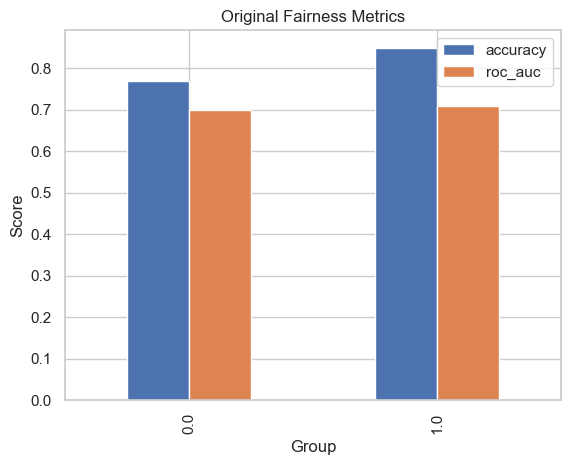

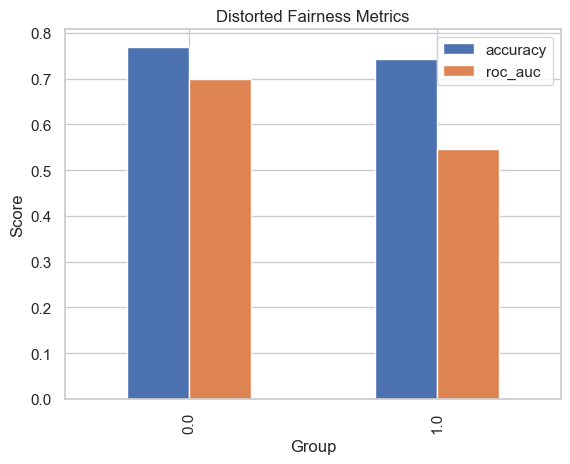

Original TPR: 0.5922, FPR: 0.1797
Distorted TPR: 0.3189, FPR: 0.1835


In [32]:
import numpy as np
import torch
import random
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Function to distort male labels by flipping 10-15% of healthy males to diseased
def distort_labels(y, a, flip_percentage=0.15, random_seed=42):
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Get indices of healthy males
    healthy_male_indices = np.where((y == 0) & (a == 1))[0]
    num_to_flip = int(flip_percentage * len(healthy_male_indices))
    
    # Select random indices to flip
    flip_indices = np.random.choice(healthy_male_indices, size=num_to_flip, replace=False)
    
    # Flip the labels
    y_distorted = y.clone()
    y_distorted[flip_indices] = 1  # Flip from healthy (0) to diseased (1)
    
    return y_distorted

# Distort labels on the test set
y_test_distorted = distort_labels(y_test, a_test, flip_percentage=0.15)

# Function to evaluate fairness metrics
def evaluate_fairness(y_true, y_pred, a_sensitive):
    acc = accuracy_score(y_true.cpu(), y_pred.cpu())
    auc = roc_auc_score(y_true.cpu(), y_pred.cpu())
    
    metric_frame = MetricFrame(
        metrics={'accuracy': accuracy_score, 'roc_auc': roc_auc_score},
        y_true=y_true.cpu(),
        y_pred=y_pred.cpu(),
        sensitive_features=a_sensitive.cpu()
    )
    
    demographic_parity_diff = demographic_parity_difference(y_true.cpu(), y_pred.cpu(), sensitive_features=a_sensitive.cpu())
    equalized_odds_diff = equalized_odds_difference(y_true.cpu(), y_pred.cpu(), sensitive_features=a_sensitive.cpu())

    return acc, auc, metric_frame, demographic_parity_diff, equalized_odds_diff

# Evaluate with original labels
y_test_tensor = torch.tensor(y_test)
test_pred_tensor = torch.tensor(test_pred)
a_test_tensor = torch.tensor(a_test)

acc_orig, auc_orig, metric_frame_orig, dp_diff_orig, eo_diff_orig = evaluate_fairness(y_test_tensor, test_pred_tensor, a_test_tensor)

# Evaluate with distorted labels
acc_distorted, auc_distorted, metric_frame_distorted, dp_diff_distorted, eo_diff_distorted = evaluate_fairness(y_test_distorted, test_pred_tensor, a_test_tensor)


# Print results
print(f"Original Test Accuracy: {acc_orig:.4f}, AUC: {auc_orig:.4f}")
print(f"Original Demographic Parity Difference: {dp_diff_orig:.4f}, Equalized Odds Difference: {eo_diff_orig:.4f}")
print(f"Distorted Test Accuracy: {acc_distorted:.4f}, AUC: {auc_distorted:.4f}")
print(f"Distorted Demographic Parity Difference: {dp_diff_distorted:.4f}, Equalized Odds Difference: {eo_diff_distorted:.4f}")

# Plot results
def plot_metric_frame(metric_frame, title="Fairness Metrics"):
    metric_frame.by_group.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Group")
    plt.ylabel("Score")
    plt.show()

# Plot fairness metrics
plot_metric_frame(metric_frame_orig, title="Original Fairness Metrics")
plot_metric_frame(metric_frame_distorted, title="Distorted Fairness Metrics")



# Compute TPR and FPR for original labels
fpr_orig, tpr_orig = compute_tpr_fpr(y_test_tensor, test_pred_tensor)

# Compute TPR and FPR for distorted labels
fpr_distorted, tpr_distorted = compute_tpr_fpr(y_test_distorted, test_pred_tensor)

# Print TPR and FPR results
print(f"Original TPR: {tpr_orig:.4f}, FPR: {fpr_orig:.4f}")
print(f"Distorted TPR: {tpr_distorted:.4f}, FPR: {fpr_distorted:.4f}")

In [35]:
metric_frame_distorted.by_group

,accuracy,roc_auc
sensitive_feature_0,,
0.0,0.769213,0.698815
1.0,0.743972,0.545274
